In [11]:
import symnum
import symnum.numpy as snp
import simsde
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad, lax
from jax.lax import scan
import matplotlib.pyplot as plt
from jax.config import config
import mici
import arviz
import corner
config.update('jax_enable_x64', True)
config.update('jax_platform_name', 'cpu')

In [12]:
def drift_func(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -snp.exp(log_I + log_C) / N - snp.exp(log_I + log_C - log_S) / (2 * N),
        snp.exp(log_S + log_C) / N - snp.exp(log_S + log_C - log_I) / (2 * N) - (λ / 2) * snp.exp(-log_I) - λ,
        α * (β - log_C)
    ])

def diff_coeff(x, θ):
    log_S, log_I, log_C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.exp((log_I + log_C - log_S) / 2) / snp.sqrt(N), 0, 0],
        [-snp.exp((log_S + log_C - log_I) / 2) / snp.sqrt(N), snp.sqrt(λ) * snp.exp(-log_I / 2), 0],
        [0, 0, σ]
    ])
    
dim_x = 3
dim_w = 3
dim_θ = 5

In [13]:
use_euler_maruyama = False
if use_euler_maruyama:
    dim_n = dim_w
    step_func = simsde.integrators.euler_maruyama_step(drift_func, diff_coeff)
else:
    dim_n = 2 * dim_w - 1
    step_func = simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff)
jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)

In [24]:
@jit
def simulate_diffusion(x_0, θ, t_seq, n_seq):
    
    def step_func(x, n_dt):
        n, dt = n_dt
        #x = jnp.clip(x, -500)
        x_ = jax_step_func(x, θ, n, dt)
        #x_next = jnp.where(x_ > -500, x_, x)
        x_next = jnp.clip(x_, -500, 500)
        return x_next, x_next
    
    _, x_seq = scan(step_func, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
    
    return jnp.concatenate((x_0[None], x_seq))

vmapped_simulate_diffusion = jit(vmap(simulate_diffusion, (None, None, None, 0)))
   

In [25]:
rng = np.random.default_rng(12345)
dt = 0.01
t_max = 20.
t_seq = np.arange(int(t_max / dt) + 1) * dt
x_0 = jnp.log(np.array([762., 1., 1.25]))
θ = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seqs = rng.standard_normal((100, t_seq.shape[0] - 1, dim_n))
x_seqs = vmapped_simulate_diffusion(x_0, θ, t_seq, n_seqs)

/tmp/ipykernel_23501/3081910250.py:4: RuntimeWarning: overflow encountered in exp
  ax.plot(t_seq, np.exp(x_seqs[:, :, i].T), color=f'C{i}', lw=0.5)


Text(0.5, 0, 'Time')

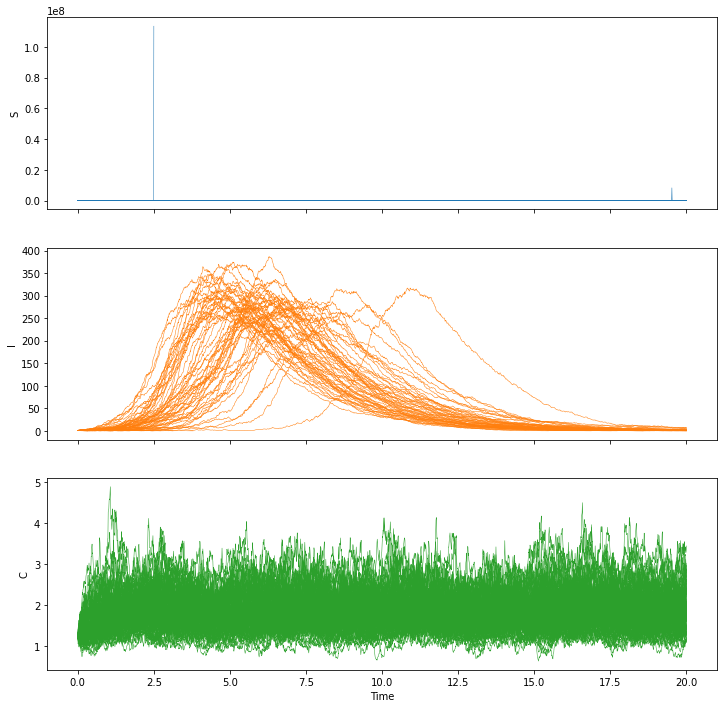

In [27]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq, np.exp(x_seqs[:, :, i].T), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

In [23]:
def drift_func(x, θ):
    S, I, C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -C * S * I / N,
        (C * S * I / N - λ * I),
        (α * (β - snp.log(C)) + σ**2 / 2) * C
    ])

def diff_coeff(x, θ):
    S, I, C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.sqrt(C * S * I / N), 0, 0],
        [-snp.sqrt(C * S * I / N), snp.sqrt(λ * I), 0],
        [0, 0, σ * C]
    ])

dim_x = 3
dim_w = 3
dim_θ = 5

In [24]:
use_euler_maruyama = True
if use_euler_maruyama:
    dim_n = dim_w
    step_func = simsde.integrators.euler_maruyama_step(
        *sde.transforms.transform_sde(snp.log, snp.exp)(drift_func, diff_coeff)
    )
else:
    dim_n = 2 * dim_w - 1
    step_func = simsde.integrators.elliptic_weak_order_2_step(
        *sde.transforms.transform_sde(snp.log, snp.exp)(drift_func, diff_coeff)
    )
jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)

NameError: name 'sde' is not defined

In [ ]:
def drift_func(x, θ):
    S, I, C = x
    α, β, σ, λ, N = θ
    return snp.array([
        -C * S * I / N,
        (C * S * I / N - λ * I),
        (α * (β - snp.log(C)) + σ**2 / 2) * C
    ])

def diff_coeff(x, θ):
    S, I, C = x
    α, β, σ, λ, N = θ
    return snp.array([
        [snp.sqrt(C * S * I / N), 0, 0],
        [-snp.sqrt(C * S * I / N), snp.sqrt(λ * I), 0],
        [0, 0, σ * C]
    ])

dim_x = 3
dim_w = 3
dim_θ = 5

In [ ]:
use_euler_maruyama = False
if use_euler_maruyama:
    dim_n = dim_w
    step_func = simsde.integrators.euler_maruyama_step(drift_func, diff_coeff)
else:
    dim_n = 2 * dim_w - 1
    step_func = simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff)
jax_step_func = symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)

In [ ]:
@jit
def simulate_diffusion(x_0, θ, t_seq, n_seq):
    
    def step_func(x, n_dt):
        n, dt = n_dt
        x = jnp.clip(x, 0)
        x_next = lax.select(x > 0, jax_step_func(x, θ, n, dt), x)
        return x_next, x_next
    
    _, x_seq = scan(step_func, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
    
    return jnp.concatenate((x_0[None], x_seq))

vmapped_simulate_diffusion = jit(vmap(simulate_diffusion, (None, None, None, 0)))
   

In [ ]:
rng = np.random.default_rng(1234)
dt = 0.01
t_max = 20.
t_seq = np.arange(int(t_max / dt) + 1) * dt
x_0 = (np.array([762., 1., 1.25]))
θ = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seqs = rng.standard_normal((100, t_seq.shape[0] - 1, dim_n))
x_seqs = vmapped_simulate_diffusion(x_0, θ, t_seq, n_seqs)

Text(0.5, 0, 'Time')

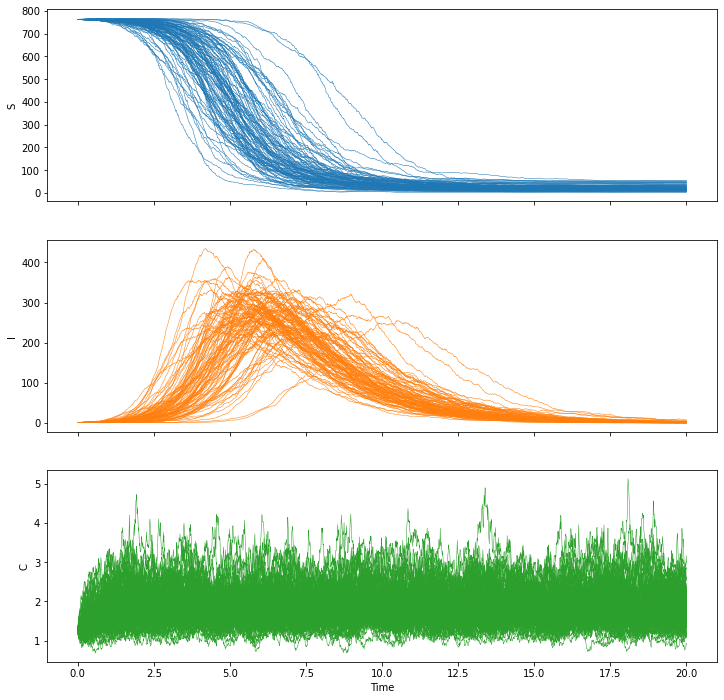

In [ ]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq, (x_seqs[:, :, i].T), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

Text(0.5, 0, 'Time')

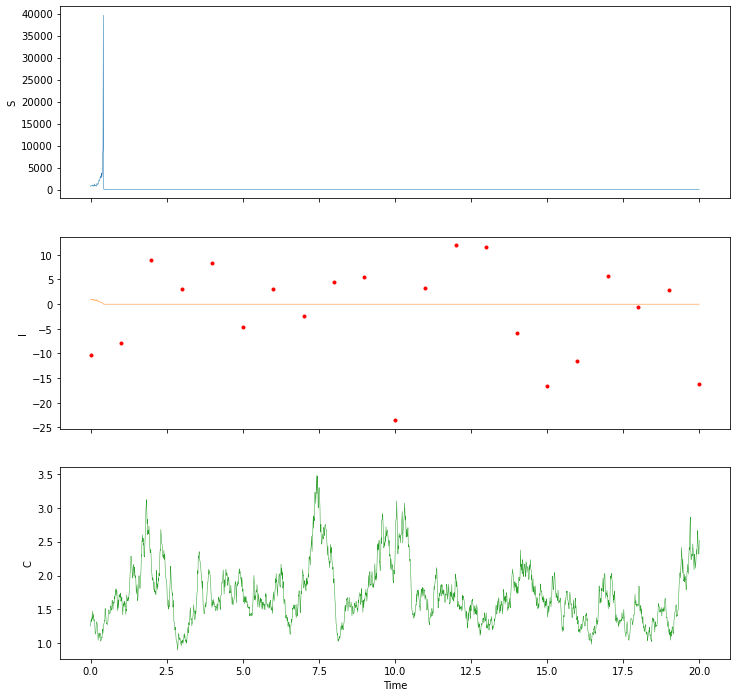

In [ ]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763., # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])
    
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.01
t_max = 20.
dt_inference = 5 * dt_simulation
dt_observation = 1.

t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
t_seq_inference = t_seq_simulation[::int(dt_inference / dt_simulation)]
obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

simulation_method = "weak_order_2"

rng_obs = np.random.default_rng(2022111122)
obs_noise_std = 10.
x_0_obs = np.log(np.array([762., 1., 1.25]))
θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)
y_obs_mean = obs_func(x_seq_obs[::int(dt_observation / dt_simulation)])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, np.exp(x_seq_obs[:, i]), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[1].plot(t_seq_inference[obs_time_indices], y_obs, 'r.')
axes[-1].set_xlabel('Time')


Sampling stage: Adaptive warm up [02:09] > Main non-adaptive [01:49]

Chain 1/2: 100%|██████████|500/500 [00:54<00:00, 9.23it/s, n_step=504., accept_stat=0.901]

Chain 2/2: 100%|██████████|500/500 [00:55<00:00, 9.08it/s, n_step=509., accept_stat=0.940]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.114,2.722,0.043,5.879,0.108,0.080,723.0,648.0,1.0
β,0.424,0.167,0.173,0.666,0.006,0.004,872.0,853.0,1.0
σ,0.085,0.108,0.002,0.253,0.004,0.003,1182.0,665.0,1.0
λ,0.510,0.025,0.463,0.556,0.001,0.000,1286.0,906.0,1.0
x_0_2,0.412,0.778,-1.081,1.804,0.027,0.024,748.0,757.0,1.0


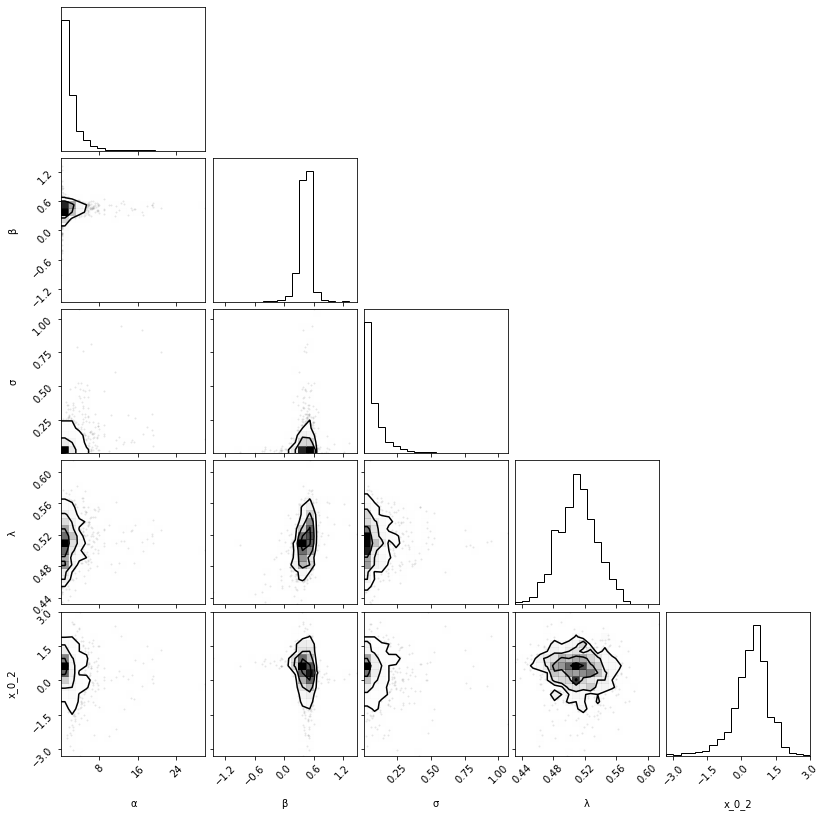

Sampling stage: Adaptive warm up [00:04] > Main non-adaptive [00:00]

ERROR:mici.samplers:Initialisation of DualAveragingStepSizeAdapter for chain 1 failed: Could not find reasonable initial step size in 100 iterations (final step size 7.888609052210118e-31). A very large final step size may indicate that the target distribution is improper such that the negative log density is flat in one or more directions while a very small final step size may indicate that the density function is insufficiently smooth at the point initialized at.
ERROR:mici.samplers:Initialisation of DualAveragingStepSizeAdapter for chain 2 failed: Could not find reasonable initial step size in 100 iterations (final step size 7.888609052210118e-31). A very large final step size may indicate that the target distribution is improper such that the negative log density is flat in one or more directions while a very small final step size may indicate that the density function is insufficiently smooth at the point initialized at.


ValueError: Can not extract posterior from {}! See /home/matt/miniconda3/envs/wo2/lib/python3.10/site-packages/arviz/data/converters.py for other conversion utilities.

In [ ]:
common_kwargs = {
    "generate_θ": generate_θ,
    "generate_x_0": generate_x_0,
    "obs_func": obs_func,
    "t_seq": t_seq_inference,
    "dim_u": dim_u,
    "dim_v_0": dim_v_0,
    "obs_noise_std": 10.,
    "obs_time_indices": obs_time_indices,
    "y_obs": y_obs
}

n_chain = 2
n_warm_up_iter = 500
n_main_iter = 500

results = {}
    
for key, generate_x_seq in generate_x_seq_functions.items():
    posterior_density_functions = get_posterior_density_functions(
        generate_x_seq=generate_x_seq, **common_kwargs
    )
    dim_q = (
        common_kwargs["dim_u"] 
        + common_kwargs["dim_v_0"]
        + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
    )
    rng = np.random.default_rng(20221114)
    system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
    integrator = mici.integrators.LeapfrogIntegrator(system)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    adapters = [
        mici.adapters.DualAveragingStepSizeAdapter(0.9),
        #mici.adapters.OnlineVarianceMetricAdapter()
    ]
    init_states = rng.standard_normal((n_chain, dim_q))
    final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
        n_warm_up_iter=n_warm_up_iter,
        n_main_iter=n_main_iter,
        init_states=init_states,
        monitor_stats=["n_step", "accept_stat"],
        trace_funcs=[trace_func],
        adapters=adapters,
    )
    summary = arviz.summary(traces)
    fig = corner.corner(traces)
    display(summary)
    display(fig)
    plt.close(fig)


In [ ]:
dim_u = 4
dim_v_0 = 1

def generate_θ(u):
    return jnp.array(
        [
            jnp.exp(u[1]),  # α
            u[2],  # β
            jnp.exp(jnp.sqrt(0.75) * u[3] + 0.5 * u[1] - 3), # σ
            jnp.exp(u[0]),  # λ,
            763., # N
        ]
    )
    
def generate_x_0(θ, v_0):
    return jnp.array([jnp.log(762.0), jnp.log(1.0), v_0[0]])
    
def obs_func(x_seq):
    return jnp.exp(x_seq[:, 1])
    
def trace_func(state):
    θ = generate_θ(state.pos[:dim_u])
    x_0 = generate_x_0(θ, state.pos[dim_u:dim_u + dim_v_0])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}
    
def get_generate_x_seq_function(step_func, lower_bound=-500):

    @jit
    def generate_x_seq(x_0, θ, n_seq, t_seq):
        
        def compute_next_state(x, n_dt):
            n, dt = n_dt
            x = jnp.clip(x, lower_bound)
            x_next = lax.select(x > lower_bound, step_func(x, θ, n, dt), x)
            return x_next, x_next
        
        _, x_seq = scan(compute_next_state, x_0, (n_seq, t_seq[1:] - t_seq[:-1]))
        
        return jnp.concatenate((x_0[None], x_seq))
        
    return generate_x_seq

def get_posterior_density_functions(
    generate_θ, 
    generate_x_0, 
    generate_x_seq,
    obs_func,
    t_seq, 
    dim_u, 
    dim_v_0, 
    obs_noise_std, 
    obs_time_indices, 
    y_obs
):
        
    @jit
    def neg_log_posterior_density(q):
        u, v_0, n = q[:dim_u], q[dim_u:dim_u + dim_v_0], q[dim_u + dim_v_0:]
        n_seq = n.reshape((t_seq.shape[0] - 1, -1))
        θ = generate_θ(u)
        x_0 = generate_x_0(θ, v_0)
        x_seq = generate_x_seq(x_0, θ, n_seq, t_seq)
        y_mean = obs_func(x_seq[obs_time_indices])
        return (
            (((y_obs - y_mean) / obs_noise_std)**2).sum() / 2 
            + y_obs.size * jnp.log(obs_noise_std) 
            + (q **2).sum() / 2
        )
        
    @jit
    def grad_neg_log_posterior_density(q):
        val, grad = value_and_grad(neg_log_posterior_density)(q)
        return grad, val
        
    return {
        "neg_log_dens": lambda q: np.asarray(neg_log_posterior_density(q)), 
        "grad_neg_log_dens": lambda q: tuple(
            np.asarray(v) for v in grad_neg_log_posterior_density(q)
        )
    }
    
step_funcs_and_dim_n = {
    "euler_maruyama": (
        simsde.integrators.euler_maruyama_step(drift_func, diff_coeff),
        dim_w
    ),
    "weak_order_2": (
        simsde.integrators.elliptic_weak_order_2_step(drift_func, diff_coeff),
        2 * dim_w - 1
    )
}

generate_x_seq_functions = {
    key: get_generate_x_seq_function(
        symnum.numpify(dim_x, dim_θ, dim_n, (), numpy_module=jnp)(step_func)
    ) 
    for key, (step_func, dim_n) in step_funcs_and_dim_n.items()
}


dt_simulation = 0.01
t_max = 20.
dt_inference = 5 * dt_simulation
dt_observation = 1.

t_seq_simulation = np.arange(int(t_max / dt_simulation) + 1) * dt_simulation
t_seq_inference = t_seq[::int(dt_inference / dt_simulation)]
obs_time_indices = slice(0, None, int(dt_observation / dt_inference))

simulation_method = "euler_maruyama"

rng_obs = np.random.default_rng(20221101)
obs_noise_std = 10.
x_0_obs = np.log(np.array([762., 1., 1.25]))
θ_obs = np.array([2.04, 0.592, 0.492, 0.505, 763.])
n_seq_obs = rng_obs.standard_normal(
    (t_seq_simulation.shape[0] - 1, step_funcs_and_dim_n[simulation_method][1])
)
x_seq_obs = generate_x_seq_functions[simulation_method](
    x_0_obs, 
    θ_obs, 
    n_seq_obs,
    t_seq_simulation
)

fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(t_seq_simulation, np.exp(x_seq_obs[:, i]), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')
display(fig)


y_obs_mean = obs_func(x_seq_obs[::int(dt_observation / dt_simulation)])
y_obs = y_obs_mean + obs_noise_std * rng_obs.standard_normal(y_obs_mean.shape)

common_kwargs = {
    "generate_θ": generate_θ,
    "generate_x_0": generate_x_0,
    "obs_func": obs_func,
    "t_seq": t_seq_inference,
    "dim_u": dim_u,
    "dim_v_0": dim_v_0,
    "obs_noise_std": 10.,
    "obs_time_indices": obs_time_indices,
    "y_obs": y_obs
}

n_chain = 2
n_warm_up_iter = 500
n_main_iter = 500

results = {}
    
for key, generate_x_seq in generate_x_seq_functions.items():
    posterior_density_functions = get_posterior_density_functions(
        generate_x_seq=generate_x_seq, **common_kwargs
    )
    dim_q = (
        common_kwargs["dim_u"] 
        + common_kwargs["dim_v_0"]
        + step_funcs_and_dim_n[key][1] * (len(t_seq_inference) - 1)
    )
    rng = np.random.default_rng(20221114)
    system = mici.systems.EuclideanMetricSystem(**posterior_density_functions)
    integrator = mici.integrators.LeapfrogIntegrator(system)
    sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng)
    adapters = [
        mici.adapters.DualAveragingStepSizeAdapter(0.9),
        #mici.adapters.OnlineVarianceMetricAdapter()
    ]
    init_states = rng.standard_normal((n_chain, dim_q))
    final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
        n_warm_up_iter=n_warm_up_iter,
        n_main_iter=n_main_iter,
        init_states=init_states,
        monitor_stats=["n_step", "accept_stat"],
        trace_funcs=[trace_func],
        adapters=adapters,
    )
    summary = arviz.summary(traces)
    fig = corner.corner(traces)
    display(summary)
    display(fig)


In [ ]:
x_seqs_prior = vmap(
    lambda q: generate_x_seq(
        q, data["t_seq"], data["dim_u"], data["dim_v_0"], data["dim_n"]
    )
)(rng.standard_normal((100, dim_q)))

/tmp/ipykernel_9730/725066354.py:4: RuntimeWarning: overflow encountered in exp
  ax.plot(data["t_seq"], np.exp(x_seqs_prior[:, :, i].T), color=f'C{i}', lw=0.5)


Text(0.5, 0, 'Time')

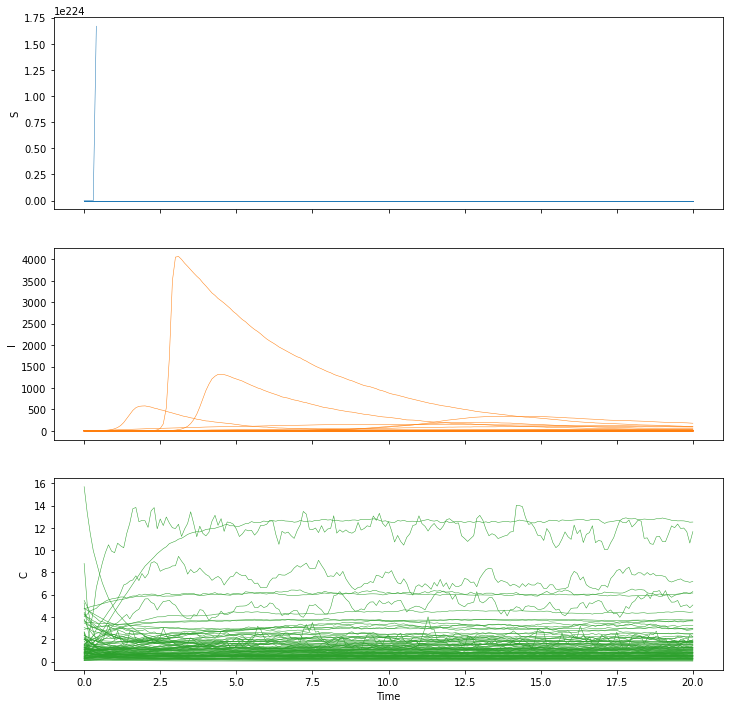

In [ ]:
fig, axes = plt.subplots(dim_x, 1, sharex=True, figsize=(12, 12))
labels = 'SIC'
for i, ax in enumerate(axes):
    ax.plot(data["t_seq"], np.exp(x_seqs_prior[:, :, i].T), color=f'C{i}', lw=0.5)
    ax.set_ylabel(labels[i])
axes[-1].set_xlabel('Time')

In [ ]:
def trace_func(state):
    θ = np.asarray(generate_θ(state.pos[:data["dim_u"]])[:-1])
    x_0 = generate_x_0(θ, state.pos[data["dim_u"]:data["dim_u"] + data["dim_v_0"]])
    return {"α": θ[0], "β": θ[1], "σ": θ[2], "λ": θ[3], "x_0_2": x_0[2]}

rng = np.random.default_rng(20221114)

system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=lambda q: np.asarray(neg_log_posterior_density(q)),
    grad_neg_log_dens = lambda q: tuple(np.asarray(v) for v in grad_neg_log_posterior_density(q))
)
integrator = mici.integrators.LeapfrogIntegrator(system)
sampler = mici.samplers.DynamicMultinomialHMC(system, integrator, rng, 10)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.9),
    #mici.adapters.OnlineVarianceMetricAdapter()
]

In [ ]:
n_chain = 4
init_states = []
tries = 0
while len(init_states) < n_chain:
    tries += 1
    q = rng.standard_normal(dim_q)
    if not np.isnan(neg_log_posterior_density(q)):
        init_states.append(q)
print(tries)

4


In [ ]:
final_states, traces, stats = sampler.sample_chains_with_adaptive_warm_up(
    n_warm_up_iter=1000,
    n_main_iter=1000,
    init_states=init_states,
    monitor_stats=["n_step", "accept_stat"],
    trace_funcs=[trace_func],
    adapters=adapters,
)

Sampling stage: Adaptive warm up [20:28] > Main non-adaptive [21:58]

Chain 1/4: 100%|██████████|1000/1000 [05:10<00:00, 3.22it/s, n_step=1.02e+03, accept_stat=1.00]

Chain 2/4: 100%|██████████|1000/1000 [05:37<00:00, 2.96it/s, n_step=1.02e+03, accept_stat=1.00]

Chain 3/4: 100%|██████████|1000/1000 [05:53<00:00, 2.83it/s, n_step=973., accept_stat=0.927]

Chain 4/4: 100%|██████████|1000/1000 [05:16<00:00, 3.16it/s, n_step=984., accept_stat=0.931]

In [ ]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,0.924,0.392,0.438,1.573,0.195,0.149,4.0,19.0,3.38
β,-0.457,0.611,-0.958,0.609,0.304,0.233,4.0,11.0,3.19
σ,0.057,0.034,0.015,0.111,0.017,0.013,5.0,11.0,3.13
λ,0.818,0.813,0.192,2.245,0.405,0.310,5.0,11.0,3.05
x_0_2,0.297,1.224,-1.545,1.584,0.610,0.467,4.0,14.0,3.76


In [ ]:
arviz.summary(traces)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.283,2.504,0.030,6.262,0.042,0.029,3426.0,2422.0,1.0
β,0.769,0.168,0.534,1.035,0.003,0.002,3917.0,2545.0,1.0
σ,0.085,0.096,0.002,0.229,0.002,0.001,4911.0,3165.0,1.0
λ,0.531,0.024,0.486,0.578,0.000,0.000,5046.0,3031.0,1.0
x_0_2,0.302,0.777,-1.293,1.582,0.013,0.011,3873.0,2678.0,1.0


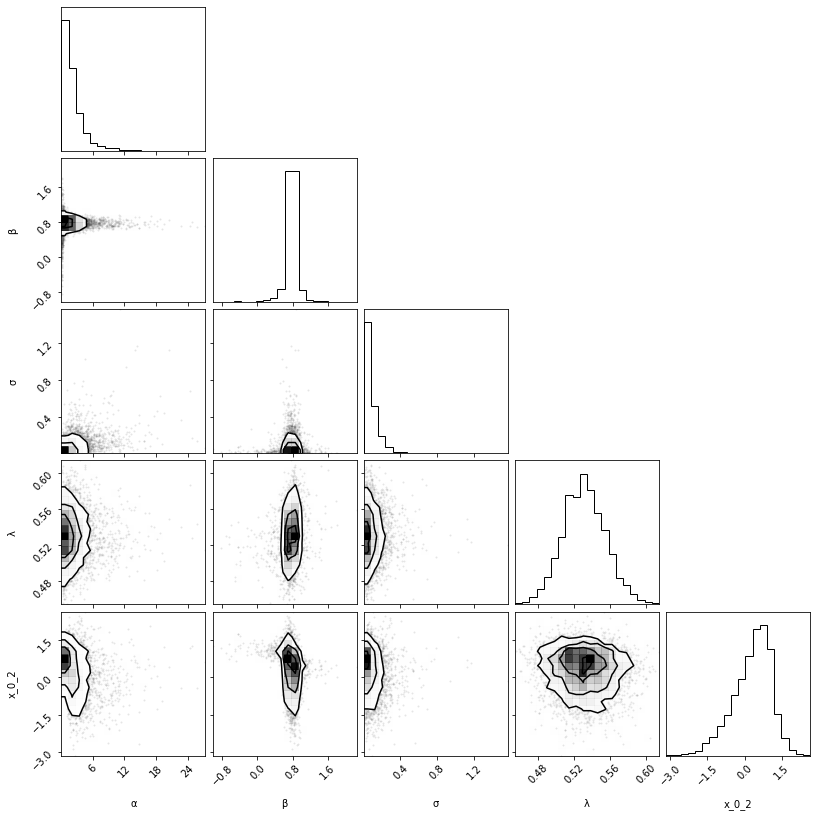

In [ ]:
_ = corner.corner(traces)